<center>

# Genómica Predictiva: Clasificación de Bacterias Resistentes a Antibióticos mediante XGBoost

**Autor:** Richard Muñoz Henao  
**Universidad:** Universidad Nacional de Colombia  
**Fecha:** 3 de noviembre de 2025

</center>

---

La resistencia a antibióticos es uno de los mayores desafíos en salud pública. La capacidad de predecir si una cepa bacteriana es resistente a ciertos antibióticos usando análisis genómicos permite acelerar diagnósticos y mejorar estrategias de tratamiento.

En este proyecto se emplea **XGBoost**, un algoritmo de **aprendizaje supervisado basado en árboles de decisión**, para clasificar bacterias según sus perfiles genómicos y su resistencia a antibióticos. Los objetivos principales son:

- Identificar patrones genéticos asociados a la resistencia.  
- Construir modelos robustos y precisos.  
- Evaluar la aplicabilidad de técnicas de **machine learning en genómica predictiva** mediante métricas como precisión, recall, F1-score y curvas ROC.


# 1. Exploración inicial de los datos

In [1]:
from Bio import SeqIO
import re
from collections import defaultdict
from pathlib import Path
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
import subprocess
import sys
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import pyrodigal
from concurrent.futures import ProcessPoolExecutor, as_completed
import cupy as cp
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np


In [2]:
iterador = SeqIO.parse("Genoma_ejemplo.fasta","fasta")
primera_secuencia = next(iterador)
print("Longitud del primer genoma: ", len(primera_secuencia.seq))
idGenoma = ".".join(primera_secuencia.id.replace("|", ".").split(".")[1:3])
print(idGenoma) # esta sera la clave para identificar cada genoma
print(f"ID: {primera_secuencia.description}\nSecuencia: {primera_secuencia.seq[:10000]}") # mostrar primeras 10000 bases nitrogenadas


Longitud del primer genoma:  467848
562.145820
ID: accn|562.145820.con.0001   SRR10969696_contig_1   [Escherichia coli S20323 | 562.145820]
Secuencia: tgccgaagtcaccgcagacagcggggaatatcaggtgctggcgcgctgggacacgccgaaggtggtgaagggtgtgagctttatgcttcgcctgaccgtaacagcggatgacggcagtgagcggctggtcagcacggcccggacgatggaaaccacttaccgcttcacacaactggcgctggggaactacaggctgacagtccgggcagtaaatgcgtgggggcagcagggcgatccggcgtcggtatcgttccggattgccgcaccggcagcgccgtcgcggattgagctgacgccgggctattttcagataaccgccacgccgcatcttgcggtttatgatccgacggtacagtttgagttctggttctcggaaaagcggattgcggatatcaggcaggttgaaaccacagcacgctatcttggcacggcgctgtactggatagccgccagtatcaatatcaaaccgggccatgattattacttttatatccgcagtgtgaacaccgttggcaaatcggcattcgtggaggctgtcggtcagccgagtgatgatgcatcaggctatctggattttttcaaaggagaaatcgggaaaacacatctggcccaggagctgtggacgcagattgataacggtcagcttgcgcctgacctggctgaaatcaggacgtccattacggatgtcagcaatgaaatcacacagaccgtcaataagaaactggaagaccagagtgcagcgatccagcagatacagaaagttcaggttgatacaaataataacctgaacagcatgtgggctgtgaagctgcagcagatgcaggacggacgcctttatattgcgggtat

# 2. Extracción de los embeddings del genoma bacteriano (K-MERS)

In [2]:
from itertools import product

K = 6
BASES = ['a','t','g','c']
kmerslist = list(product(BASES, repeat = K))
kmerslist = [''.join(x) for x in kmerslist]
kmersdict = {x: 0 for x in kmerslist} # Convertir en diccionario, clave: numero de apariciones del kmer

print("longitud de kmerslist: ", len(kmerslist))
print(kmerslist[:100])

longitud de kmerslist:  4096
['aaaaaa', 'aaaaat', 'aaaaag', 'aaaaac', 'aaaata', 'aaaatt', 'aaaatg', 'aaaatc', 'aaaaga', 'aaaagt', 'aaaagg', 'aaaagc', 'aaaaca', 'aaaact', 'aaaacg', 'aaaacc', 'aaataa', 'aaatat', 'aaatag', 'aaatac', 'aaatta', 'aaattt', 'aaattg', 'aaattc', 'aaatga', 'aaatgt', 'aaatgg', 'aaatgc', 'aaatca', 'aaatct', 'aaatcg', 'aaatcc', 'aaagaa', 'aaagat', 'aaagag', 'aaagac', 'aaagta', 'aaagtt', 'aaagtg', 'aaagtc', 'aaagga', 'aaaggt', 'aaaggg', 'aaaggc', 'aaagca', 'aaagct', 'aaagcg', 'aaagcc', 'aaacaa', 'aaacat', 'aaacag', 'aaacac', 'aaacta', 'aaactt', 'aaactg', 'aaactc', 'aaacga', 'aaacgt', 'aaacgg', 'aaacgc', 'aaacca', 'aaacct', 'aaaccg', 'aaaccc', 'aataaa', 'aataat', 'aataag', 'aataac', 'aatata', 'aatatt', 'aatatg', 'aatatc', 'aataga', 'aatagt', 'aatagg', 'aatagc', 'aataca', 'aatact', 'aatacg', 'aatacc', 'aattaa', 'aattat', 'aattag', 'aattac', 'aattta', 'aatttt', 'aatttg', 'aatttc', 'aattga', 'aattgt', 'aattgg', 'aattgc', 'aattca', 'aattct', 'aattcg', 'aattcc', 'aatgaa', 

In [3]:
from itertools import product

Kp = 3

AMINOACIDS = [
    'A','C','D','E','F',
    'G','H','I','K','L',
    'M','N','P','Q','R',
    'S','T','V','W','Y'
]

kmerslistp = [''.join(x) for x in product(AMINOACIDS, repeat=Kp)]
kmersdictp = {kmer: 0 for kmer in kmerslistp}

print("Número de 3-mers proteicos:", len(kmerslist))
print(kmerslist[:100])


Número de 3-mers proteicos: 4096
['aaaaaa', 'aaaaat', 'aaaaag', 'aaaaac', 'aaaata', 'aaaatt', 'aaaatg', 'aaaatc', 'aaaaga', 'aaaagt', 'aaaagg', 'aaaagc', 'aaaaca', 'aaaact', 'aaaacg', 'aaaacc', 'aaataa', 'aaatat', 'aaatag', 'aaatac', 'aaatta', 'aaattt', 'aaattg', 'aaattc', 'aaatga', 'aaatgt', 'aaatgg', 'aaatgc', 'aaatca', 'aaatct', 'aaatcg', 'aaatcc', 'aaagaa', 'aaagat', 'aaagag', 'aaagac', 'aaagta', 'aaagtt', 'aaagtg', 'aaagtc', 'aaagga', 'aaaggt', 'aaaggg', 'aaaggc', 'aaagca', 'aaagct', 'aaagcg', 'aaagcc', 'aaacaa', 'aaacat', 'aaacag', 'aaacac', 'aaacta', 'aaactt', 'aaactg', 'aaactc', 'aaacga', 'aaacgt', 'aaacgg', 'aaacgc', 'aaacca', 'aaacct', 'aaaccg', 'aaaccc', 'aataaa', 'aataat', 'aataag', 'aataac', 'aatata', 'aatatt', 'aatatg', 'aatatc', 'aataga', 'aatagt', 'aatagg', 'aatagc', 'aataca', 'aatact', 'aatacg', 'aatacc', 'aattaa', 'aattat', 'aattag', 'aattac', 'aattta', 'aatttt', 'aatttg', 'aatttc', 'aattga', 'aattgt', 'aattgg', 'aattgc', 'aattca', 'aattct', 'aattcg', 'aattcc', 'aatga

## Funcion para extraer los k-mers de una secuencia de bases nitrogenadas

In [81]:
def getkmers(seq, idGenoma = "", k=K):
    seq = str(seq)
    counts = defaultdict(int)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmersdict:
            counts[kmer] += 1
    return counts

def getkmersp(seq, idGenoma = "", k=Kp):
    seq = str(seq)
    counts = defaultdict(int)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmersdictp:
            counts[kmer] += 1
    return counts

def procesar_kmers_combinados(idGenoma, dna_seq, prot_seq):
    # k-mers DNA
    dna_counts = getkmers(dna_seq, idGenoma)

    # k-mers proteína
    prot_counts = getkmersp(prot_seq, idGenoma)

    # vector ordenado: DNA primero, proteína después
    vector = []

    for kmer in kmerslist:
        vector.append(dna_counts.get(kmer, 0))

    for kmer in kmerslistp:
        vector.append(prot_counts.get(kmer, 0))

    return vector


## Funcion para extraer orfs
Los orfs son los fragmentos del genoma que codifican para proteinas, por lo tanto las mutaciones de resistencia se suelen presentar en estas subsecuencias entonces vale la pena aislarlos.

In [82]:
seqs = [str(rec.seq) for rec in SeqIO.parse("Genoma_ejemplo.fasta", "fasta")]
genoma = "NNNNNNNNNN".join(seqs)
predictor = pyrodigal.GeneFinder(meta=False)
predictor.train(sequence=genoma)

def procesarGenes(secuencia, idGenoma, predictor = predictor):
    genes = predictor.find_genes(secuencia)
    orfConcatenado = "".join(str(g.translate()) for g in genes)
    return idGenoma, orfConcatenado

## Procesar los genomas para obtener los datos tabulares con las características
En este paso concatenamos todos los contigs correspondientes a un mismo genoma, extraemos los k-mers y colocamos los resultados en una lista con diccionarios.

In [85]:
%%time
registroKmersSuceptible = [] 
registroKmersResistant = []
regexGenomaid = re.compile(r"\|\s(\d*\.\d*)\]")

for carpeta in [Path("suceptible/"), Path("resistant/")]:
    registroKmers = registroKmersSuceptible if carpeta == Path("suceptible/") else registroKmersResistant
    for archivoFasta in sorted(carpeta.iterdir()):
        print("\n")
        print("Concatenando contigs", archivoFasta)
        genomas = defaultdict(list)
        
        for contig in SeqIO.parse(archivoFasta, "fasta"):
            idGenoma = regexGenomaid.findall(contig.description)
            idGenoma = ".".join(idGenoma)
            genomas[idGenoma].append(str(contig.seq))
        
        genomasSecuencias = {}
        a = 1 
        while genomas:
            # popitem() extrae y elimina el elemento del diccionario original para liberar RAM
            idGenoma, contigs = genomas.popitem()
            
            # 1. Unimos los contigs originales
            secuencia_original = "".join(contigs).lower()
            
            # 2. Generamos el reverso complemento
            # Usamos la clase Seq de Biopython para el cálculo rápido
            reverso_comp = str(Seq(secuencia_original).reverse_complement())
            
            # 3. Concatenamos ambos con un espaciador de seguridad
            genomasSecuencias[idGenoma] = secuencia_original + "NNNNNNNNNN" + reverso_comp
            if a ==1:
                print(genomasSecuencias[idGenoma][:15])
            a = 2
            # Limpieza manual para el recolector de basura
            del contigs
        
        contador = 0
        with ProcessPoolExecutor() as executor: # Encontrar orfs
            futures = {executor.submit(procesarGenes, seq, idG): idG for idG, seq in genomasSecuencias.items()}
            for future in as_completed(futures):
                idGenoma, orfSeq = future.result()
                genomas[idGenoma] = orfSeq
                contador += 1
                print(f"\rORFs encontrados con éxito {contador} / {len(genomasSecuencias)}", end="")
        
        contador = 0
        with ProcessPoolExecutor() as executor:
            futures = {
                executor.submit(
                    procesar_kmers_combinados,
                    idGenoma,
                    genomasSecuencias[idGenoma],  # DNA
                    genomas[idGenoma]             # PROTEÍNA
                ): idGenoma
                for idGenoma in genomasSecuencias
            }
        
            for future in as_completed(futures):
                registroKmers.append(future.result())
                contador += 1
                print(f"\rProcesando k-mers del genoma {contador} / {len(genomas)}", end="")





Concatenando contigs suceptible/suceptible1.fasta
tgccgaagtcaccgc
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible10.fasta
agtagtgtggggtct
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible11.fasta
gcagtacctgtaata
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible12.fasta
attacccgccgccag
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible13.fasta
cttatactcccacat
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible14.fasta
cccaccggcgcgggc
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible15.fasta
agcttttcattctga
Procesando k-mers del genoma 27 / 27

Concatenando contigs suceptible/suceptible2.fasta
cttatactcccacat
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible3.fasta
catagagtgtaaaga
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptib

## Convertir en dataframe, agregar etiquetas de resistencia y exportar como csv

In [97]:
columnas = []

# DNA k-mers
for kmer in kmerslist:
    columnas.append(f"DNA_{kmer}")

# Protein k-mers
for kmer in kmerslistp:
    columnas.append(f"PROT_{kmer}")

columnas.append('Resistant')

dfResistant = pd.DataFrame(registroKmersResistant).T
dfSuceptible = pd.DataFrame(registroKmersSuceptible).T
dfResistant["Resistant"] = True
dfSuceptible["Resistant"] = False
df = pd.concat([dfSuceptible, dfResistant], ignore_index=False)
df = df.fillna(0)
df.columns = columnas
df.to_csv("kmers.csv", index = True)

# 3. Visualizar datos

In [116]:
import pandas as pd
columnas = []

# DNA k-mers
for kmer in kmerslist:
    columnas.append(f"DNA_{kmer}")

# Protein k-mers
for kmer in kmerslistp:
    columnas.append(f"PROT_{kmer}")

columnas.append('Resistant')


df = pd.read_csv("kmers.csv")
print(df.shape)
df.columns = columnas
df.tail(10)




(6460, 12097)


,DNA_aaaaaa,DNA_aaaaat,DNA_aaaaag,DNA_aaaaac,DNA_aaaata,DNA_aaaatt,DNA_aaaatg,DNA_aaaatc,DNA_aaaaga,DNA_aaaagt,...,PROT_YYN,PROT_YYP,PROT_YYQ,PROT_YYR,PROT_YYS,PROT_YYT,PROT_YYV,PROT_YYW,PROT_YYY,Resistant
6450,7545,7134,5806,6229,5107,4548,5210,5691,3811,2849,...,124,172,190,218,240,154,136,64,108,True
6451,7722,7097,5957,6382,5211,4505,5359,5669,3848,2955,...,130,172,202,218,246,156,138,54,114,True
6452,7782,7189,5949,6487,5120,4658,5307,5794,3944,2918,...,138,156,188,226,226,150,146,66,100,True
6453,7550,6959,5825,6207,5058,4422,5260,5573,3705,2904,...,126,174,192,210,248,162,142,64,110,True
6454,7409,6809,5713,6191,4933,4335,5099,5529,3669,2869,...,128,164,196,216,208,138,124,56,94,True
6455,7640,7023,5902,6419,5082,4508,5318,5640,3721,2957,...,144,182,204,220,226,162,140,66,102,True
6456,7176,6706,5683,6047,4972,4279,5209,5437,3677,2823,...,128,170,188,206,238,150,124,54,104,True
6457,7651,6964,5890,6381,5083,4407,5257,5615,3718,2961,...,138,170,190,218,244,152,126,62,114,True
6458,7811,7117,5970,6465,5182,4452,5336,5740,3765,3022,...,144,170,186,224,243,156,134,64,108,True
6459,7461,6868,5776,6253,5058,4367,5278,5585,3677,2871,...,134,164,188,212,234,140,128,58,110,True


# 4. Entrenamiento con XGBoost

## Pasar de frecuencia absoluta a frecuencia relativa

In [135]:
N_DNA = 4096    # 4^6
N_PROT = 8000  # 20^3

y = df["Resistant"].values
x = df.drop("Resistant", axis=1)

# Separar bloques
x_dna   = x.iloc[:, :N_DNA]
x_prot  = x.iloc[:, N_DNA:N_DNA + N_PROT]

# Normalización independiente
x_dna = x_dna.div(x_dna.sum(axis=1), axis=0)
x_prot = x_prot.div(x_prot.sum(axis=1), axis=0)

# Recombinar
x = pd.concat([x_dna, x_prot], axis=1)

x = x.fillna(0.0)
x = x.values

## Split de los datos

In [118]:
# Convertir todo a GPU
x = cp.array(x)
y = cp.array(y)

# Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20) # train se utilizara con validacion cruzada

# Crear DMatrix en GPU
dtrain = xgb.DMatrix(x_train, label=y_train)
deval = xgb.DMatrix(x_test, label=y_test)

print(y)
print(x)

[False False False ...  True  True  True]
[[7.36624228e-04 6.69919307e-04 5.64319676e-04 ... 3.93494985e-05
  1.76394304e-05 3.52788607e-05]
 [7.32795606e-04 6.88812571e-04 5.58871388e-04 ... 4.38976098e-05
  2.09660226e-05 3.53801631e-05]
 [7.38244784e-04 6.75370984e-04 5.67003906e-04 ... 4.65367941e-05
  2.03188819e-05 3.86714204e-05]
 ...
 [7.33253622e-04 6.67413178e-04 5.64483575e-04 ... 4.14792146e-05
  2.04104072e-05 3.75288132e-05]
 [7.40188592e-04 6.74423532e-04 5.65731135e-04 ... 4.35467460e-05
  2.07984458e-05 3.50973773e-05]
 [7.21949909e-04 6.64569358e-04 5.58903991e-04 ... 4.24461166e-05
  1.92333966e-05 3.64771315e-05]]


## Busqueda de hiperparametros con optimización bayesiana

In [8]:
import cupy as cp
from sklearn.model_selection import train_test_split
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import KFold

space = { # Espacio de búsqueda de Hyperopt
    'max_depth': hp.choice('max_depth', [8, 9, 10, 11, 12]),
    'learning_rate': hp.uniform('learning_rate', 0.030, 0.1),
    'subsample': hp.uniform('subsample', 0.75, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1.0),
    'min_child_weight': hp.choice('min_child_weight', [3, 4, 5, 6]),
    'gamma': hp.uniform('gamma', 0.2, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.1),
    'reg_lambda': hp.uniform('reg_lambda', 1.0, 1.5)
}

def objective(params): # Funcion objetivo utilizando kfolds
    params_train = {
        **params,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'device': 'cuda',
        'tree_method': 'hist',
        'max_bin': 64
    }
    
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in kfold.split(x_train):
        x_fold_train = x_train[train_idx]
        y_fold_train = y_train[train_idx]
        x_fold_val = x_train[val_idx]
        y_fold_val = y_train[val_idx]
        
        dfold_train = xgb.DMatrix(x_fold_train, label=y_fold_train)
        dfold_val = xgb.DMatrix(x_fold_val, label=y_fold_val)
        
        bst = xgb.train(
            params_train,
            dfold_train,
            num_boost_round=50,
            evals=[(dfold_val, 'eval')],
            early_stopping_rounds=10,
            verbose_eval=False
        )
        
        scores.append(bst.best_score)
    
    return {'loss': cp.mean(cp.array(scores)).item(), 'status': STATUS_OK}

trials = Trials() 
best_params = fmin( # Optimización bayesiana
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=600,
    trials=trials,
    verbose=1
)

# Convertir índices de hp.choice a valores reales
best_params['max_depth'] = [8, 9, 10, 11, 12][best_params['max_depth']]
#best_params['min_child_weight'] = [3, 4, 5, 6][best_params['min_child_weight']]
print("Mejores parámetros:", best_params)
print("Mejor logloss:", trials.best_trial['result']['loss'])

  0%|                                   | 0/600 [00:00<?, ?trial/s, best loss=?]

/home/unalmed/anaconda3/envs/p310/lib/python3.10/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


100%|████| 600/600 [3:15:56<00:00, 19.59s/trial, best loss: 0.35210527033298544]
Mejores parámetros: {'colsample_bytree': np.float64(0.9053050699650227), 'gamma': np.float64(0.23426168470442288), 'learning_rate': np.float64(0.09837668487354659), 'max_depth': 8, 'min_child_weight': np.int64(3), 'reg_alpha': np.float64(0.03581350948720452), 'reg_lambda': np.float64(1.3340148120607287), 'subsample': np.float64(0.8956735423354062)}
Mejor logloss: 0.35210527033298544


In [102]:
best_params = {'colsample_bytree': np.float64(0.8213569587359635), 'gamma': np.float64(0.2187777862237753), 'learning_rate': np.float64(0.05733622412275338), 'max_depth': 10, 'min_child_weight': 6, 'reg_alpha': np.float64(0.07517193717807188), 'reg_lambda': np.float64(1.1464794780531444), 'subsample': np.float64(0.8136143994277922)}

## Entrenar modelo con los mejores hiperparametros encontrados

In [119]:
%%time

final_params = {
    **best_params,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss', #'auc'
    'device': 'cuda',
    'tree_method': 'hist',
    'max_bin': 128
}

bst_final = xgb.train(
    final_params,
    dtrain,
    num_boost_round=1000,
    evals=[(deval, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=True
)

print("Iteración óptima:", bst_final.best_iteration)

[0]	eval-logloss:0.66264
[1]	eval-logloss:0.64165
[2]	eval-logloss:0.62274
[3]	eval-logloss:0.60373
[4]	eval-logloss:0.58797
[5]	eval-logloss:0.57201
[6]	eval-logloss:0.55818
[7]	eval-logloss:0.54532
[8]	eval-logloss:0.53396
[9]	eval-logloss:0.52246
[10]	eval-logloss:0.51214
[11]	eval-logloss:0.50341
[12]	eval-logloss:0.49367
[13]	eval-logloss:0.48641
[14]	eval-logloss:0.47847
[15]	eval-logloss:0.46972
[16]	eval-logloss:0.46156
[17]	eval-logloss:0.45491
[18]	eval-logloss:0.44900
[19]	eval-logloss:0.44318
[20]	eval-logloss:0.43757
[21]	eval-logloss:0.43244
[22]	eval-logloss:0.42766
[23]	eval-logloss:0.42188
[24]	eval-logloss:0.41698
[25]	eval-logloss:0.41217
[26]	eval-logloss:0.40741
[27]	eval-logloss:0.40277
[28]	eval-logloss:0.39901
[29]	eval-logloss:0.39516
[30]	eval-logloss:0.39182
[31]	eval-logloss:0.38866
[32]	eval-logloss:0.38616
[33]	eval-logloss:0.38232
[34]	eval-logloss:0.37863
[35]	eval-logloss:0.37614
[36]	eval-logloss:0.37353
[37]	eval-logloss:0.37014
[38]	eval-logloss:0.36

# 5. Visualización y métricas de los resultados

In [120]:
# Predicciones y evaluación
y_pred_proba = bst_final.predict(deval)
y_pred = (y_pred_proba > 0.5).astype(int)
y_test_cpu = cp.asnumpy(y_test)
accuracy = (y_pred == y_test_cpu).mean()

resultados = pd.DataFrame()
resultados['test'] = y_test.get().astype(int)
resultados['pred'] = y_pred.astype(int)
resultados.tail(10)

,test,pred
1282,1,0
1283,0,0
1284,0,0
1285,1,1
1286,1,1
1287,1,1
1288,0,0
1289,0,0
1290,1,1
1291,0,0


## Métricas de clasificación binaria

\begin{align*}
\text{Precision (Precisión)} &= \frac{TP}{TP + FP} \\[2mm]
\text{Recall (Sensibilidad)} &= \frac{TP}{TP + FN} \\[2mm]
\text{F1-score} &= 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} \\[2mm]
\text{Support} &= \text{Número de muestras reales de cada clase} \\[2mm]
\text{Accuracy (Exactitud)} &= \frac{TP + TN}{TP + TN + FP + FN} \\[2mm]
\text{Macro Average} &= \frac{1}{2} (\text{métrica para clase True} + \text{métrica para clase False}) \\[2mm]
\text{Weighted Average} &= \frac{(\text{métrica clase True} \cdot \text{support True}) + (\text{métrica clase False} \cdot \text{support False})}{\text{support True} + \text{support False}} \\[2mm]
\text{ROC-AUC} &= \text{Área bajo la curva ROC, que mide la capacidad de separar clases} 
\end{align*}


In [136]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np
from sklearn.metrics import (roc_auc_score,roc_curve,classification_report,)
import matplotlib.pyplot as plt

y_true = y_test_cpu
y_pred_labels = y_pred

# Reporte detallado de las metricas
roc_auc = roc_auc_score(y_true, y_pred_proba)
report = classification_report(y_true, y_pred_labels)
print(report)
print(f"ROC-AUC: {roc_auc:.4f}")

              precision    recall  f1-score   support

       False       0.89      0.90      0.89       571
        True       0.92      0.91      0.92       721

    accuracy                           0.91      1292
   macro avg       0.90      0.91      0.91      1292
weighted avg       0.91      0.91      0.91      1292

ROC-AUC: 0.9546


# Matriz de confusión

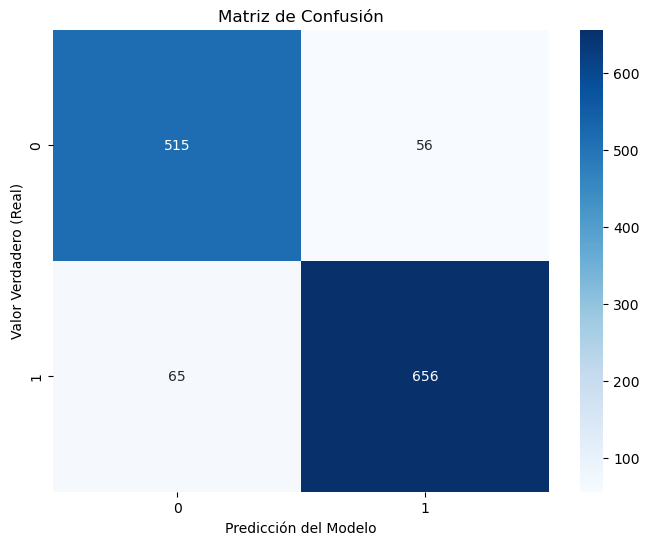

In [137]:
cm = confusion_matrix(y_test.get(), y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Matriz de Confusión')
plt.ylabel('Valor Verdadero (Real)')
plt.xlabel('Predicción del Modelo')
plt.show()

# Curva ROC

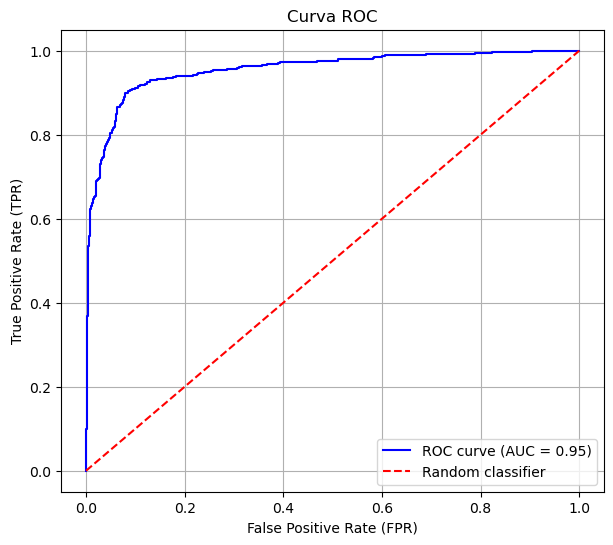

In [123]:

fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Interpretacion del modelo XGBoost mediante SHAP

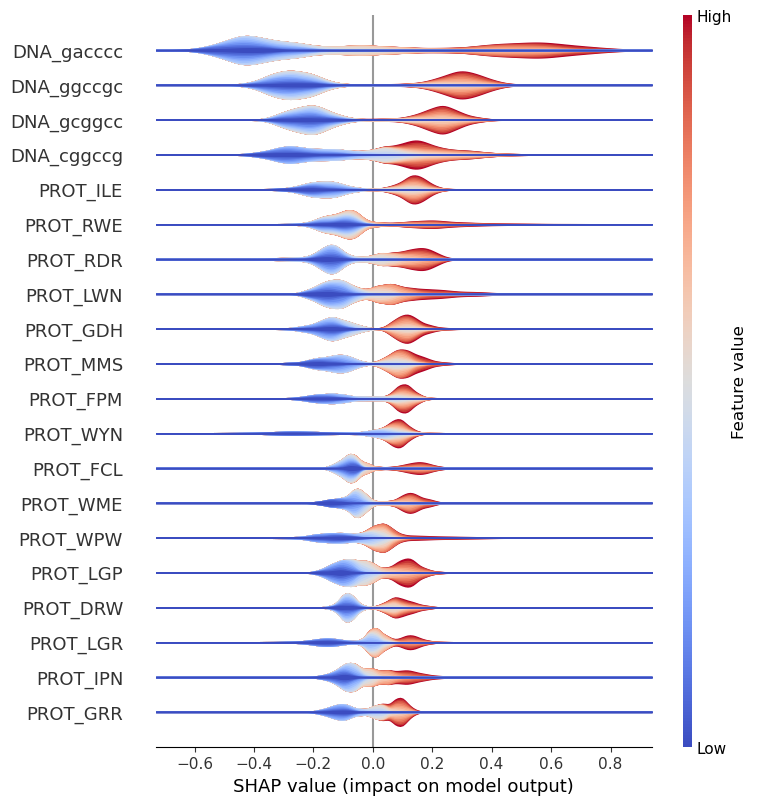

In [124]:
import shap
explainer = shap.TreeExplainer(bst_final)
shap_values = explainer.shap_values(x_test)

exp = shap.Explanation(
    values=shap_values, 
    base_values=explainer.expected_value, 
    data=x_test.get(), 
    feature_names=columnas[:-1]
)

shap.plots.violin(exp, plot_type="layered_violin", max_display=20)


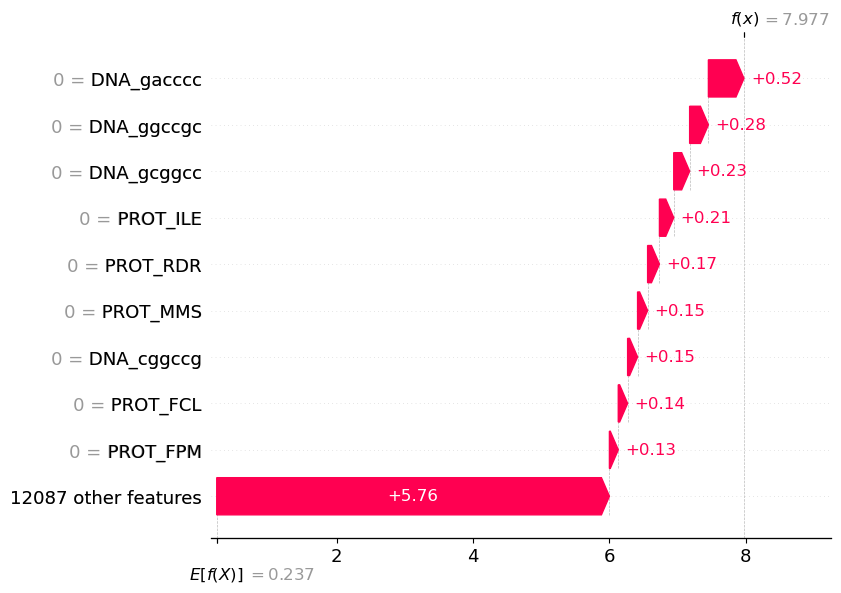

In [164]:
shap.plots.waterfall(exp[14]) # Explicar la primera fila

In [143]:
# 1. Calculamos el impacto promedio solo para la clase "Resistente"
# Filtramos los valores SHAP que son mayores a 0 (los que aportan a la resistencia)
pos_shap_values = exp.values.copy()
pos_shap_values[pos_shap_values < 0] = 0 # Ignoramos lo que resta puntos

# 2. Creamos un ranking de los k-mers más importantes para la resistencia
importancias = pos_shap_values.mean(axis=0)
ranking_kmers = pd.DataFrame({
    'kmer': columnas[:-1],
    'importancia_shap': importancias
}).sort_values(by='importancia_shap', ascending=False)

# 3. Mostrar los top 20 candidatos
print("Top 20 k-mers candidatos a ser parte de genes de resistencia:")
print(ranking_kmers.head(20))

Top 20 k-mers candidatos a ser parte de genes de resistencia:
             kmer  importancia_shap
2303   DNA_gacccc          0.201192
2811   DNA_ggccgc          0.138209
2991   DNA_gcggcc          0.104881
3774   DNA_cggccg          0.101794
7079     PROT_ILE          0.074349
10059    PROT_RWE          0.073690
8067     PROT_LWN          0.068432
9750     PROT_RDR          0.067739
8311     PROT_MMS          0.065093
5946     PROT_FPM          0.062712
6142     PROT_GDH          0.060713
11687    PROT_WYN          0.059364
11499    PROT_WME          0.056047
5725     PROT_FCL          0.053494
5194     PROT_DRW          0.048697
7808     PROT_LGP          0.047626
11554    PROT_WPW          0.047542
7810     PROT_LGR          0.044995
11645    PROT_WVL          0.044452
6390     PROT_GRR          0.043959


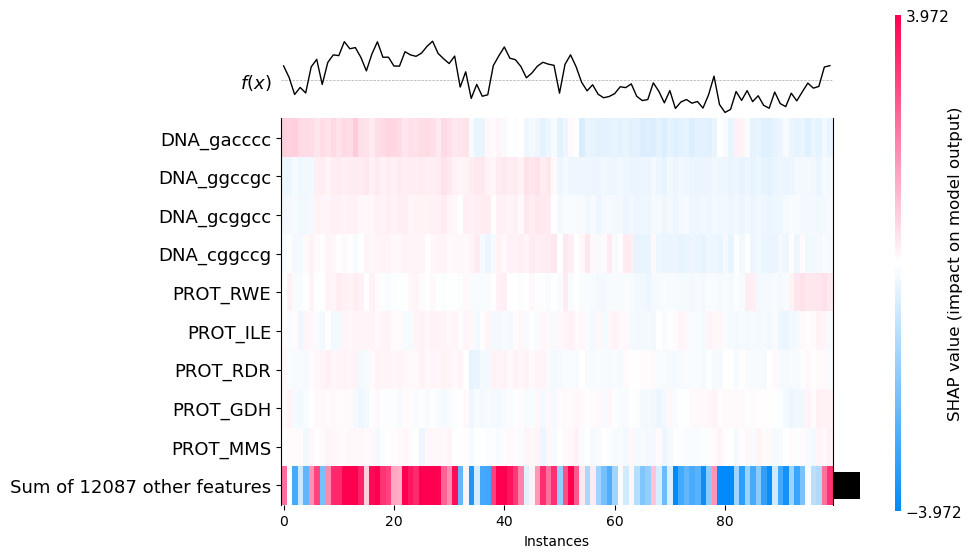

<Axes: xlabel='Instances'>

In [148]:
# Muestra cómo se agrupan los k-mers en las diferentes muestras
shap.plots.heatmap(exp[0:100], max_display=10)

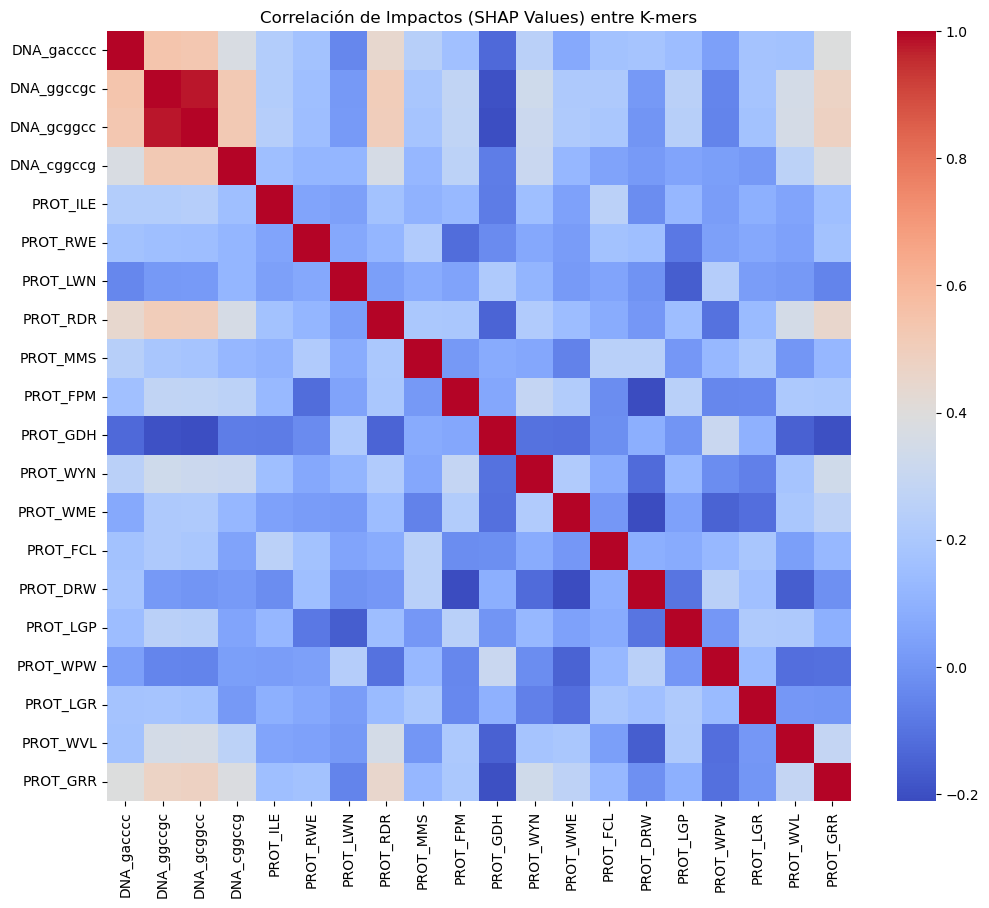

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Convertimos los SHAP values a un DataFrame de Pandas
df_shap = pd.DataFrame(exp.values, columns=columnas[:-1])

# 2. Elegimos los top 20 k-mers más importantes (para que sea legible)
top_20_cols = ranking_kmers.head(20)['kmer'].values
df_top_shap = df_shap[top_20_cols]

# 3. Calculamos la matriz de correlación
corr_matrix = df_top_shap.corr()

# 4. Graficamos
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlación de Impactos (SHAP Values) entre K-mers")
plt.show()

# Identificar genes resistentes

In [1]:
import re
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor, as_completed
from Bio import SeqIO
from Bio.Seq import Seq
import pyrodigal

# --- CONFIGURACIÓN DE BÚSQUEDA ---
TARGET_KMERS = ['gacccc', 'ggccgc', 'gcggcc']

def contar_coincidencias_objetivo(secuencia_adn):
    """
    Cuenta la suma total de apariciones de los 3 kmers objetivo en una secuencia.
    """
    secuencia_adn = secuencia_adn.lower() # Aseguramos minúsculas
    score = 0
    k = 6
    for i in range(len(secuencia_adn) - k + 1):
        kmer_actual = secuencia_adn[i:i+k]
        if kmer_actual in TARGET_KMERS:
            score += 1
    return score

# Configuración inicial del predictor (como en tu código original)
# Nota: Asumo que ya tienes el archivo "Genoma_ejemplo.fasta" para el entrenamiento
# Si no, comenta las líneas de entrenamiento y usa meta=True
try:
    seqs = [str(rec.seq) for rec in SeqIO.parse("Genoma_ejemplo.fasta", "fasta")]
    genoma_train = "NNNNNNNNNN".join(seqs)
    predictor = pyrodigal.GeneFinder(meta=False)
    predictor.train(sequence=genoma_train)
except FileNotFoundError:
    print("Advertencia: No se encontró Genoma_ejemplo.fasta, usando modo meta=True")
    predictor = pyrodigal.GeneFinder(meta=True)

def procesarGenesBuscarObjetivo(secuencia, idGenoma, predictor=predictor):
    """
    Identifica genes, extrae su ADN y busca los kmers objetivo.
    Retorna una lista con los mejores genes encontrados en este contig.
    """
    genes_encontrados = predictor.find_genes(secuencia)
    
    mejores_candidatos_locales = []
    
    for gen in genes_encontrados:
        # Extraemos la secuencia de ADN del gen
        # Pyrodigal permite obtener la secuencia de nucleótidos del gen directamente
        gen_dna = gen.sequence()
        
        # Calculamos el score basado en tus 3 kmers
        score = contar_coincidencias_objetivo(gen_dna)
        
        # Si el score es mayor a 0 (o un umbral que definas), lo guardamos
        if score > 0:
            traduccion = str(gen.translate())
            mejores_candidatos_locales.append({
                'idGenoma': idGenoma,
                'score': score,
                'dna_seq': gen_dna,
                'prot_seq': traduccion,
                'inicio': gen.begin,
                'fin': gen.end
            })
            
    return mejores_candidatos_locales
    
lista_genes_destacados = [] # Aquí guardaremos los resultados finales
regexGenomaid = re.compile(r"\|\s(\d*\.\d*)\]")

# Procesamos ambas carpetas
for carpeta in [Path("resistant/")]:
    # Verificamos si la carpeta existe para evitar errores
    if not carpeta.exists():
        print(f"Carpeta {carpeta} no encontrada, saltando...")
        continue
        
    print(f"Leyendo carpeta: {carpeta}")

    for archivoFasta in sorted(carpeta.iterdir()):
        print(f"Procesando archivo: {archivoFasta.name}")
        genomas = defaultdict(list)
        
        # 1. Lectura de Contigs
        for contig in SeqIO.parse(archivoFasta, "fasta"):
            busqueda_id = regexGenomaid.findall(contig.description)
            # Manejo de error si el regex no encuentra nada
            idGenoma = ".".join(busqueda_id) if busqueda_id else contig.id 
            genomas[idGenoma].append(str(contig.seq))
        
        genomasSecuencias = {}
        
        # 2. Preprocesamiento (Concatenación + Reverso Complemento)
        while genomas:
            idGenoma, contigs = genomas.popitem()
            secuencia_original = "".join(contigs).lower()
            reverso_comp = str(Seq(secuencia_original).reverse_complement())
            # Concatenamos
            genomasSecuencias[idGenoma] = secuencia_original + "NNNNNNNNNN" + reverso_comp
            del contigs

        # 3. Búsqueda de Genes en Paralelo
        print(f"  Buscando genes objetivo en {len(genomasSecuencias)} genomas...")
        
        with ProcessPoolExecutor() as executor:
            futures = {
                executor.submit(procesarGenesBuscarObjetivo, seq, idG): idG 
                for idG, seq in genomasSecuencias.items()
            }
            
            for future in as_completed(futures):
                resultados = future.result()
                # Agregamos los resultados encontrados a la lista maestra
                if resultados:
                    lista_genes_destacados.extend(resultados)

# --- RESULTADOS FINALES ---
print("\n" + "="*50)
print("ANÁLISIS COMPLETADO")
print("="*50)

# Ordenamos todos los genes encontrados por score (de mayor a menor)
lista_genes_destacados.sort(key=lambda x: x['score'], reverse=True)

print(f"Total de genes con coincidencias encontrados: {len(lista_genes_destacados)}")

# Mostramos el TOP 5
print("\n--- TOP 5 GENES CON MÁS COINCIDENCIAS ---")
for i, gen in enumerate(lista_genes_destacados[:5]):
    print(f"\n# {i+1} | Genoma: {gen['idGenoma']} | Score: {gen['score']}")
    print(f"   Secuencia DNA (inicia): {gen['dna_seq'][:60]}...")
    print(f"   Traducción (inicia):    {gen['prot_seq'][:60]}...")

Leyendo carpeta: resistant
Procesando archivo: resistant1.fasta
  Buscando genes objetivo en 200 genomas...
Procesando archivo: resistant10.fasta
  Buscando genes objetivo en 200 genomas...
Procesando archivo: resistant11.fasta
  Buscando genes objetivo en 200 genomas...
Procesando archivo: resistant12.fasta
  Buscando genes objetivo en 200 genomas...
Procesando archivo: resistant13.fasta
  Buscando genes objetivo en 200 genomas...
Procesando archivo: resistant14.fasta
  Buscando genes objetivo en 200 genomas...
Procesando archivo: resistant15.fasta
  Buscando genes objetivo en 200 genomas...
Procesando archivo: resistant16.fasta
  Buscando genes objetivo en 200 genomas...
Procesando archivo: resistant17.fasta
  Buscando genes objetivo en 200 genomas...
Procesando archivo: resistant18.fasta
  Buscando genes objetivo en 200 genomas...
Procesando archivo: resistant19.fasta
  Buscando genes objetivo en 33 genomas...
Procesando archivo: resistant2.fasta
  Buscando genes objetivo en 200 gen

In [5]:
from pathlib import Path
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO

# 1. Crear la carpeta si no existe
output_dir = Path("genes_resistentes")
output_dir.mkdir(exist_ok=True)

# 2. Guardar cada gen en su propio archivo FASTA
for i, gen in enumerate(lista_genes_destacados[:5]):
    # Crear el objeto de secuencia con un encabezado informativo
    # El ID es lo primero que lee un programa, el description es el resto del encabezado
    registro = SeqRecord(
        Seq(gen['dna_seq']), 
        id=f"GenResistente{i+1}", 
        description=f"idGenoma:{gen['idGenoma']} | Score_Kmers:{gen['score']} | Coordenadas:{gen['inicio']}-{gen['fin']}"
    )
    
    # Nombre del archivo: genes_resistentes/genResistente1.fasta, etc.
    nombre_archivo = output_dir / f"genResistente{i+1}.fasta"
    
    # Escribir el archivo
    SeqIO.write(registro, nombre_archivo, "fasta")

print(f"Proceso terminado. Se han creado {len(lista_genes_destacados[:5])} archivos en la carpeta '{output_dir}'.")

Proceso terminado. Se han creado 5 archivos en la carpeta 'genes_resistentes'.
